# Pizza invetory tracking & optimization

### Data Loading and cleaning

In [1]:
import pandas as pd
import numpy as np
import optuna
from datetime import datetime as dt, timedelta
from collections import defaultdict

# Load the pizza sales data
df = pd.read_excel('Data Model - Pizza Sales.xlsx')
df["order_date"] = pd.to_datetime(df["order_date"])

# Clean ingredient names
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('慛', 'N')
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('Artichokes', 'Artichoke')
df['pizza_ingredients'] = df['pizza_ingredients'].str.replace('Anchories', 'Anchovies')
print(f"Data loaded and cleaned with {df.shape[0]} rows and {df.shape[1]} columns.")

c:\Users\nborn\OneDrive\Dokumente\Projekte\TechLabs\restaurant_menu_optimizer\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Data loaded and cleaned with 48620 rows and 12 columns.


### Inventory constants

In [2]:
#Dictionary with the ingredients and their mass in g per pizza
ingredient_masses_grams = {
    # meats & fish
    "Sliced Ham": 90, "Pepperoni": 80, "Bacon": 70, "Calabrese Salami": 80,
    "Capocollo": 80, "Chicken": 100, "Barbecued Chicken": 100,
    "Prosciutto di San Daniele": 60, "Prosciutto": 60,
    "Beef Chuck Roast": 110, "Italian Sausage": 100, "Chorizo Sausage": 100,
    "Soppressata Salami": 80, "Anchovies": 35,
    "Genoa Salami": 80, "Coarse Sicilian Salami": 80,
    "Luganega Sausage": 100, "Pancetta": 70, "Nduja Salami": 70,
    # cheeses
    "Mozzarella Cheese": 130, "Provolone Cheese": 90, "Smoked Gouda Cheese": 90,
    "Romano Cheese": 25, "Blue Cheese": 60, "Feta Cheese": 70,
    "Asiago Cheese": 70, "Goat Cheese": 60, "Ricotta Cheese": 80,
    "Gorgonzola Piccante Cheese": 60, "Parmigiano Reggiano Cheese": 25,
    "Fontina Cheese": 90, "Gouda Cheese": 90, "Brie Carre Cheese": 60,
    # vegetables & herbs
    "Mushrooms": 70, "Red Onions": 50, "Onions": 50, "Caramelized Onions": 60,
    "Red Peppers": 70, "Green Peppers": 70, "Friggitello Peppers": 40,
    "Jalapeno Peppers": 25, "Peperoncini verdi": 25,
    "Tomatoes": 80, "Plum Tomatoes": 80, "Sun-dried Tomatoes": 35,
    "Spinach": 40, "Arugula": 20, "Artichoke": 70,
    "Zucchini": 70, "Eggplant": 70, "Garlic": 6, "Oregano": 2,
    "Kalamata Olives": 45, "Green Olives": 45, "Pineapple": 80, "Corn": 60,
    "Cilantro": 3, "Pears": 60, "Thyme": 1,
    # sauces
    "Chipotle Sauce": 50, "Barbecue Sauce": 70, "Alfredo Sauce": 80,
    "Pesto Sauce": 50, "Thai Sweet Chilli Sauce": 45,
}

# Convert to kg for calculations
ingredient_masses_kg = {k: v / 1000 for k, v in ingredient_masses_grams.items()}

print(f"Ingredient masses defined for {len(ingredient_masses_kg)} ingredients")


Ingredient masses defined for 64 ingredients


In [3]:
# Shelf life in days for each ingredient
shelf_life_days = {
    "Sliced Ham": 5, "Pepperoni": 14, "Bacon": 7, "Calabrese Salami": 14,
    "Capocollo": 10, "Chicken": 5, "Barbecued Chicken": 5,
    "Prosciutto di San Daniele": 10, "Prosciutto": 10,
    "Beef Chuck Roast": 5, "Italian Sausage": 7, "Chorizo Sausage": 10,
    "Soppressata Salami": 14, "Anchovies": 30,
    "Genoa Salami": 14, "Coarse Sicilian Salami": 14,
    "Luganega Sausage": 7, "Pancetta": 10, "Nduja Salami": 10,
    "Mozzarella Cheese": 7, "Provolone Cheese": 14, "Smoked Gouda Cheese": 14,
    "Romano Cheese": 30, "Blue Cheese": 10, "Feta Cheese": 7,
    "Asiago Cheese": 14, "Goat Cheese": 7, "Ricotta Cheese": 7,
    "Gorgonzola Piccante Cheese": 10, "Parmigiano Reggiano Cheese": 30,
    "Fontina Cheese": 14, "Gouda Cheese": 14, "Brie Carre Cheese": 7,
    "Mushrooms": 3, "Red Onions": 14, "Onions": 14, "Caramelized Onions": 5,
    "Red Peppers": 5, "Green Peppers": 5, "Friggitello Peppers": 5,
    "Jalapeno Peppers": 7, "Peperoncini verdi": 7,
    "Tomatoes": 5, "Plum Tomatoes": 5, "Sun-dried Tomatoes": 30,
    "Spinach": 3, "Arugula": 3, "Artichoke": 5,
    "Zucchini": 5, "Eggplant": 5, "Garlic": 30, "Oregano": 30,
    "Kalamata Olives": 30, "Green Olives": 30, "Pineapple": 5, "Corn": 7,
    "Cilantro": 3, "Pears": 7, "Thyme": 30,
    "Chipotle Sauce": 30, "Barbecue Sauce": 30, "Alfredo Sauce": 7,
    "Pesto Sauce": 7, "Thai Sweet Chilli Sauce": 30,
}
print(f"Shelf life defined for {len(shelf_life_days)} ingredients")


Shelf life defined for 64 ingredients


In [4]:
#pizza recipes 
df['ingredient_list'] = df['pizza_ingredients'].str.split(',').apply(lambda lst: [ing.strip() for ing in lst])
recipes_dict = df[['pizza_name','ingredient_list']].drop_duplicates('pizza_name').set_index('pizza_name')['ingredient_list'].to_dict()
print(f"There are {len(recipes_dict)} individual pizzas")
print(recipes_dict)

There are 32 individual pizzas
{'The Hawaiian Pizza': ['Sliced Ham', 'Pineapple', 'Mozzarella Cheese'], 'The Classic Deluxe Pizza': ['Pepperoni', 'Mushrooms', 'Red Onions', 'Red Peppers', 'Bacon'], 'The Five Cheese Pizza': ['Mozzarella Cheese', 'Provolone Cheese', 'Smoked Gouda Cheese', 'Romano Cheese', 'Blue Cheese', 'Garlic'], 'The Italian Supreme Pizza': ['Calabrese Salami', 'Capocollo', 'Tomatoes', 'Red Onions', 'Green Olives', 'Garlic'], 'The Mexicana Pizza': ['Tomatoes', 'Red Peppers', 'Jalapeno Peppers', 'Red Onions', 'Cilantro', 'Corn', 'Chipotle Sauce', 'Garlic'], 'The Thai Chicken Pizza': ['Chicken', 'Pineapple', 'Tomatoes', 'Red Peppers', 'Thai Sweet Chilli Sauce'], 'The Prosciutto and Arugula Pizza': ['Prosciutto di San Daniele', 'Arugula', 'Mozzarella Cheese'], 'The Barbecue Chicken Pizza': ['Barbecued Chicken', 'Red Peppers', 'Green Peppers', 'Tomatoes', 'Red Onions', 'Barbecue Sauce'], 'The Greek Pizza': ['Kalamata Olives', 'Feta Cheese', 'Tomatoes', 'Garlic', 'Beef Chuc

### Daily pizza demand

In [5]:
# Calculate daily pizza demand
daily_demand_pizzas = df.set_index('order_date').groupby('pizza_name')['quantity'].resample('D').sum().unstack(level=0).fillna(0)
print(f"Daily pizza demand calculated for {len(daily_demand_pizzas)} days")
daily_demand_pizzas


Daily pizza demand calculated for 365 days


pizza_name,The Barbecue Chicken Pizza,The Big Meat Pizza,The Brie Carre Pizza,The Calabrese Pizza,The California Chicken Pizza,The Chicken Alfredo Pizza,The Chicken Pesto Pizza,The Classic Deluxe Pizza,The Five Cheese Pizza,The Four Cheese Pizza,...,The Prosciutto and Arugula Pizza,The Sicilian Pizza,The Soppressata Pizza,The Southwest Chicken Pizza,The Spicy Italian Pizza,The Spinach Pesto Pizza,The Spinach Supreme Pizza,The Spinach and Feta Pizza,The Thai Chicken Pizza,The Vegetables + Vegetables Pizza
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,11.0,5.0,0.0,1.0,4.0,2.0,4.0,10.0,7.0,6.0,...,4.0,4.0,1.0,7.0,5.0,2.0,5.0,2.0,8.0,3.0
2015-01-02,9.0,8.0,0.0,0.0,5.0,1.0,2.0,6.0,6.0,3.0,...,4.0,6.0,4.0,6.0,11.0,2.0,8.0,4.0,9.0,5.0
2015-01-03,7.0,8.0,1.0,1.0,12.0,5.0,3.0,5.0,4.0,7.0,...,7.0,7.0,1.0,5.0,4.0,6.0,2.0,2.0,10.0,7.0
2015-01-04,11.0,0.0,2.0,2.0,5.0,5.0,1.0,4.0,4.0,4.0,...,5.0,3.0,0.0,1.0,6.0,3.0,4.0,4.0,5.0,1.0
2015-01-05,2.0,4.0,2.0,0.0,8.0,9.0,2.0,9.0,6.0,5.0,...,3.0,6.0,2.0,4.0,3.0,4.0,2.0,3.0,6.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,4.0,5.0,1.0,1.0,3.0,0.0,3.0,8.0,2.0,4.0,...,1.0,4.0,1.0,2.0,4.0,3.0,1.0,1.0,5.0,9.0
2015-12-28,2.0,3.0,1.0,1.0,5.0,2.0,3.0,9.0,2.0,4.0,...,5.0,4.0,5.0,3.0,2.0,2.0,2.0,3.0,6.0,3.0
2015-12-29,4.0,6.0,1.0,2.0,6.0,1.0,1.0,3.0,3.0,3.0,...,3.0,2.0,3.0,1.0,3.0,4.0,0.0,1.0,5.0,1.0


### Daily ingredient demand 

In [6]:
def calculate_daily_ingredient_usage(daily_demand_pizzas, recipes_dict, ingredient_masses_kg): #Returns dataframe ingredient_usage
    """
    Convert daily pizza demand to daily ingredient usage.
    
    Parameters:
    - daily_demand_pizzas: DataFrame with dates as index and pizza names as columns
    - recipes_dict: Dictionary mapping pizza names to their ingredient lists
    - ingredient_masses_kg: Dictionary mapping ingredients to their mass per pizza in kg
    
    Returns:
    - DataFrame with dates as index and ingredients as columns showing daily usage in kg
    """
    
    # Get all unique ingredients from recipes
    all_ingredients = set()
    for ingredients in recipes_dict.values():
        all_ingredients.update(ingredients)
    all_ingredients = sorted(list(all_ingredients))
    
    # Initialize ingredient usage dataframe
    ingredient_usage = pd.DataFrame(index=daily_demand_pizzas.index, columns=all_ingredients, dtype=float).fillna(0.0)
    
    # Calculate daily ingredient usage
    for date in daily_demand_pizzas.index:
        for pizza_name in daily_demand_pizzas.columns:
            pizza_quantity = daily_demand_pizzas.loc[date, pizza_name]
            
            if pizza_quantity > 0 and pizza_name in recipes_dict:
                for ingredient in recipes_dict[pizza_name]:
                    if ingredient in ingredient_masses_kg:
                        total_mass = pizza_quantity * ingredient_masses_kg[ingredient]
                        ingredient_usage.loc[date, ingredient] += total_mass
    
    return ingredient_usage
print('Function created')

Function created


In [7]:
# Calculate daily ingredient usage
daily_ingredient_usage = calculate_daily_ingredient_usage(daily_demand_pizzas, recipes_dict, ingredient_masses_kg)

print(f"Daily ingredient usage calculated: {daily_ingredient_usage.shape}")
print(f"Total ingredients tracked: {len(daily_ingredient_usage.columns)}")
daily_ingredient_usage

Daily ingredient usage calculated: (365, 64)
Total ingredients tracked: 64


,Alfredo Sauce,Anchovies,Artichoke,Arugula,Asiago Cheese,Bacon,Barbecue Sauce,Barbecued Chicken,Beef Chuck Roast,Blue Cheese,...,Romano Cheese,Sliced Ham,Smoked Gouda Cheese,Soppressata Salami,Spinach,Sun-dried Tomatoes,Thai Sweet Chilli Sauce,Thyme,Tomatoes,Zucchini
order_date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,0.16,0.070,1.47,0.08,0.77,1.05,0.77,1.1,0.55,0.42,...,0.175,0.36,0.63,0.08,1.20,0.175,0.360,0.000,8.16,0.35
2015-01-02,0.08,0.210,2.17,0.08,0.91,0.98,0.63,0.9,0.77,0.36,...,0.150,0.90,0.54,0.32,1.12,0.105,0.405,0.000,8.00,0.63
2015-01-03,0.40,0.210,2.10,0.14,0.84,0.91,0.49,0.7,0.77,0.24,...,0.100,0.72,0.36,0.08,1.44,0.315,0.450,0.001,6.80,0.70
2015-01-04,0.40,0.175,1.47,0.10,0.70,0.28,0.77,1.1,0.44,0.24,...,0.100,0.36,0.36,0.00,0.84,0.105,0.225,0.002,5.04,0.28
2015-01-05,0.72,0.175,1.47,0.06,1.05,0.91,0.14,0.2,0.22,0.36,...,0.150,0.45,0.54,0.16,0.96,0.175,0.270,0.002,4.72,0.35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,0.00,0.105,0.77,0.02,0.28,0.91,0.28,0.4,0.33,0.12,...,0.050,0.45,0.18,0.08,0.84,0.105,0.225,0.001,4.32,0.63
2015-12-28,0.16,0.140,0.91,0.10,0.42,0.84,0.14,0.2,0.22,0.12,...,0.050,0.63,0.18,0.40,0.84,0.070,0.270,0.001,4.00,0.35
2015-12-29,0.08,0.140,0.98,0.06,0.21,0.63,0.28,0.4,0.22,0.18,...,0.075,0.36,0.27,0.24,0.60,0.175,0.225,0.001,3.04,0.07


### Calculation of initial Inventory parameters

In [8]:
def calculate_initial_inventory_parameters(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
    """
    Calculate all inventory parameters for each ingredient according to specifications:
    - Initial stock: Total demand in first 2 weeks * 2.2
    - Maximum stock: Max daily demand in first 3 months * 0.95
    - Minimum stock: Max daily demand in first 3 months (manually triggered)
    - Shelf life: From predefined dictionary
    
    Parameters:
    - daily_ingredient_usage: DataFrame with daily ingredient usage in kg
    - ingredient_masses_kg: Dictionary with ingredient masses per pizza in kg
    - shelf_life_days: Dictionary with shelf life for each ingredient in days
    
    Returns:
    - DataFrame with all inventory parameters
    """
    
    # Filter first two weeks for initial stock calculation
    first_two_weeks = daily_ingredient_usage[
        (daily_ingredient_usage.index >= '2015-01-01') & 
        (daily_ingredient_usage.index < '2015-01-15')
    ]
    
    # Filter first three months for max/min stock calculation
    first_three_months = daily_ingredient_usage[
        (daily_ingredient_usage.index >= '2015-01-01') & 
        (daily_ingredient_usage.index < '2015-04-01')
    ]
    
    # Calculate parameters for each ingredient
    inventory_parameters = []
    
    for ingredient in daily_ingredient_usage.columns:
        # Initial stock: total demand in first 2 weeks * 2.2
        initial_stock = first_two_weeks[ingredient].sum() * 1.53
        
        # Maximum stock: max daily demand in first 3 months * 0.95
        max_daily_demand = first_three_months[ingredient].max()
        max_stock = max_daily_demand * 1.49
        
        # Minimum stock: same as max daily demand (manually triggered)
        min_stock = max_daily_demand*0.41
        
        # Shelf life
        shelf_life = shelf_life_days.get(ingredient, 7)  # default 7 days
        
        inventory_parameters.append({
            'ingredient': ingredient,
            'initial_stock_kg': initial_stock,
            'max_stock_kg': max_stock,
            'min_stock_kg': min_stock,
            'shelf_life_days': shelf_life,
            'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
        })
    
    return pd.DataFrame(inventory_parameters).set_index('ingredient')

# Calculate inventory parameters
inventory_parameters = calculate_initial_inventory_parameters(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)

print("Inventory parameters calculated:")
print(inventory_parameters)
print(f"\nTotal ingredients: {len(inventory_parameters)}")


Inventory parameters calculated:
                         initial_stock_kg  max_stock_kg  min_stock_kg  \
ingredient                                                              
Alfredo Sauce                     5.63040       1.07280       0.29520   
Anchovies                         3.05235       0.46935       0.12915   
Artichoke                        32.77260       4.38060       1.20540   
Arugula                           1.83600       0.29800       0.08200   
Asiago Cheese                    16.27920       2.08600       0.57400   
...                                   ...           ...           ...   
Sun-dried Tomatoes                3.32010       0.62580       0.17220   
Thai Sweet Chilli Sauce           6.19650       0.87165       0.23985   
Thyme                             0.01989       0.00745       0.00205   
Tomatoes                        134.76240      12.39680       3.41120   
Zucchini                         11.45970       1.56450       0.43050   

                 

In [ ]:
{'init_factor': 1.0040061984208064, 'min_factor': 0.7338829274989584, 'max_factor': 2.888223410189339} 

### Invetory simulation function

In [9]:
def simulate_inventory(df, inventory_parameters, recipes_dict, ingredient_masses_kg, 
                      start_date='2015-01-01', end_date='2015-04-01',
                      restock_interval_days=7, alarm_threshold=3):
    """
    Same I/O and logic as your version:
    - FEFO consumption
    - Weekly + interval restocks
    - Weekly alarm threshold shortens interval
    - Counts safety_stock_alarms
    Returns a dict with: lost_demand, waste_kg (per ingredient), waste_total_kg,
    restock_events, final_restock_interval_days, safety_stock_alarms
    """

    # --- Prep dates and a simple working copy of sales ---
    df_sim = df.copy()
    df_sim["date"] = pd.to_datetime(df_sim["order_date"]).dt.date
    days = pd.date_range(start_date, end_date, freq="D").date
    start_day = days[0]

    # --- Read parameters as plain dicts ---
    min_stock   = {k: float(v) for k, v in inventory_parameters['min_stock_kg'].items()}
    max_stock   = {k: float(v) for k, v in inventory_parameters['max_stock_kg'].items()}
    shelf_life  = {k: int(v)   for k, v in inventory_parameters['shelf_life_days'].items()}

    # --- Inventory structure: {ingredient: [(amount_kg, expiry_date), ...]} ---
    inventory = {}
    for ing in inventory_parameters.index:
        init_amt = float(inventory_parameters.loc[ing, 'initial_stock_kg'])
        exp_date = start_day + timedelta(days=int(inventory_parameters.loc[ing, 'shelf_life_days']))
        inventory[ing] = [(init_amt, exp_date)]

    # --- Tracking ---
    lost_demand = 0
    waste = defaultdict(float)
    weekly_alarms = 0
    safety_stock_alarms = 0
    restock_events = 0
    current_restock_interval = int(restock_interval_days)
    week_start = start_day

    # --- Helpers (kept simple) ---
    def get_current_stock(ingredient):
        total = 0.0
        for amt, _ in inventory.get(ingredient, []):
            total += float(amt)
        return float(total)

    def remove_expired(today):
        for ing in list(inventory.keys()):
            new_batches = []
            for amt, exp in inventory[ing]:
                if today >= exp:
                    waste[ing] += float(amt)
                else:
                    new_batches.append((float(amt), exp))
            inventory[ing] = new_batches

    def consume_fefo(ingredient, needed_amount):
        # Sort batches by soonest expiry first
        if ingredient not in inventory:
            return False
        inventory[ingredient].sort(key=lambda t: t[1])

        remaining_need = float(needed_amount)
        new_batches = []

        for amt, exp in inventory[ingredient]:
            if remaining_need <= 0:
                new_batches.append((amt, exp))
                continue
            use = min(float(amt), remaining_need)
            left = float(amt) - use
            remaining_need -= use
            if left > 1e-9:
                new_batches.append((left, exp))

        inventory[ingredient] = new_batches
        return remaining_need <= 1e-9

    # --- Simulation loop day by day ---
    for day in days:
        # 1) Expiry cleanup → waste
        remove_expired(day)

        # 2) Fulfil orders of the day
        day_orders = df_sim[df_sim["date"] == day]
        for _, order in day_orders.iterrows():
            pizza = order['pizza_name']
            qty = int(order['quantity'])

            if pizza not in recipes_dict:
                continue

            # Build needed ingredient amounts for this order
            needed = {}
            can_fulfill = True
            for ing in recipes_dict[pizza]:
                amt_needed = float(qty) * float(ingredient_masses_kg[ing])
                needed[ing] = amt_needed
                if get_current_stock(ing) < amt_needed:
                    can_fulfill = False
                    break

            if can_fulfill:
                # Consume all needed ingredients using FEFO
                for ing, amt_needed in needed.items():
                    ok = consume_fefo(ing, amt_needed)
                    if not ok:
                        can_fulfill = False
                        break

            if not can_fulfill:
                lost_demand += 1

        # 3) Manual low-stock alarms
        for ing in list(inventory.keys()):
            curr = get_current_stock(ing)
            thr = float(min_stock.get(ing, 0.0))
            if curr <= thr:
                weekly_alarms += 1
                safety_stock_alarms += 1

        # 4) Restock checks
        restock_today = False

        # Weekly Monday restock
        if day.weekday() == 0:
            restock_today = True

        # Interval-based restock from start day
        days_since_start = (day - start_day).days
        if days_since_start % current_restock_interval == 0:
            restock_today = True

        if restock_today:
            restock_events += 1
            for ing in inventory_parameters.index:
                target = float(max_stock.get(ing, 0.0))
                curr = get_current_stock(ing)
                add = max(0.0, target - curr)
                if add > 0.0:
                    exp = day + timedelta(days=int(shelf_life.get(ing, 7)))
                    inventory[ing].append((add, exp))

        # 5) Weekly interval adjustment
        if day >= week_start + timedelta(days=6):
            if weekly_alarms >= int(alarm_threshold):
                current_restock_interval = max(3, current_restock_interval - 1)
            weekly_alarms = 0
            week_start = day + timedelta(days=1)

    return {
        'lost_demand': int(lost_demand),
        'waste_kg': dict(waste),
        'waste_total_kg': round(float(sum(waste.values())), 3),
        'restock_events': int(restock_events),
        'final_restock_interval_days': int(current_restock_interval),
        'safety_stock_alarms': int(safety_stock_alarms)
    }


### Testing of Simulation function

In [ ]:
# === Run simulations with different restock intervals ===
restock_intervals = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
simulation_results = []

for interval in restock_intervals:
    result = simulate_inventory(
        df=df,
        inventory_parameters=inventory_parameters,
        recipes_dict=recipes_dict,
        ingredient_masses_kg=ingredient_masses_kg,
        start_date='2015-01-01',
        end_date='2015-03-31',
        restock_interval_days=interval,
        alarm_threshold=3
    )
    result['restock_interval_days'] = interval
    simulation_results.append(result)

# turn into DataFrame
results_df = pd.json_normalize(simulation_results)
results_df = results_df.set_index("restock_interval_days").sort_index()

# expand waste_kg dict into columns
if "waste_kg" in results_df.columns:
    waste_df = pd.DataFrame(results_df.pop("waste_kg").tolist(),
                            index=results_df.index).add_prefix("waste_kg_")
    results_df = results_df.join(waste_df)

# show selected outputs
print("Simulation Results:")
print(results_df[["lost_demand","waste_total_kg","restock_events",
                  "safety_stock_alarms","final_restock_interval_days"]])


Simulation Results:
                       lost_demand  waste_total_kg  restock_events  \
restock_interval_days                                                
1                             3083         766.902              42   
2                             3241         797.736              39   
3                             3182         781.278              39   
4                             3313         794.566              37   
5                             3035         755.590              38   
6                             3247         810.153              38   
7                             3720         819.866              35   
8                             4506         838.799              31   
9                             3836         805.920              34   
10                            3949         819.097              33   
11                            5319         882.448              29   
12                            4460         839.021              30   


In [11]:
# Sum of all ingredient masses used throughout the whole year
total_ingredient_usage_year = daily_ingredient_usage.loc['2015-01-01':'2015-12-31'].sum()
grand_total_usage = total_ingredient_usage_year.sum()
grand_total_usage

np.float64(16931.997000000003)

In [12]:
waste_percentage = results_df['waste_total_kg'].min() / grand_total_usage*100
waste_percentage

np.float64(4.462497837673843)

In [13]:
lost_demand_percentage = results_df['lost_demand'].min() / df['quantity'].sum()*100
lost_demand_percentage

np.float64(6.12216081010207)

In [15]:
# Bayesian Optimization for inventory parameters using Optuna



def objective(trial):
    # Suggest factors for initial, min, and max stock
    init_factor = trial.suggest_float('init_factor', 1.0, 3.0)
    min_factor = trial.suggest_float('min_factor', 0.1, 0.9)
    max_factor = trial.suggest_float('max_factor', 0.7, 3.0)
    alpha = 0.1  # weight for waste in the score

    # Generate new inventory parameters
    def custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
        first_two_weeks = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-01-15')
        ]
        first_three_months = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-04-01')
        ]
        inventory_parameters = []
        for ingredient in daily_ingredient_usage.columns:
            initial_stock = first_two_weeks[ingredient].sum() * init_factor
            max_daily_demand = first_three_months[ingredient].max()
            max_stock = max_daily_demand * max_factor
            min_stock = max_daily_demand * min_factor
            shelf_life = shelf_life_days.get(ingredient, 7)
            inventory_parameters.append({
                'ingredient': ingredient,
                'initial_stock_kg': initial_stock,
                'max_stock_kg': max_stock,
                'min_stock_kg': min_stock,
                'shelf_life_days': shelf_life,
                'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
            })
        return pd.DataFrame(inventory_parameters).set_index('ingredient')

    # Calculate parameters and run simulation
    params = custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)
    result = simulate_inventory(
        df=df,
        inventory_parameters=params,
        recipes_dict=recipes_dict,
        ingredient_masses_kg=ingredient_masses_kg,
        start_date='2015-01-01',
        end_date='2015-04-01',
        restock_interval_days=5,
        alarm_threshold=2
    )
    score = result['lost_demand'] + alpha * result['waste_total_kg']
    return score

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=200)

print("Best parameters:", study.best_params)
print("Best score:", study.best_value)

[I 2025-09-13 10:02:10,941] A new study created in memory with name: no-name-ce3d9f66-407e-40e5-bbc8-7b94c92073d9
[I 2025-09-13 10:02:11,877] Trial 0 finished with value: 6103.2834 and parameters: {'init_factor': 2.7771834338285712, 'min_factor': 0.43880576756211653, 'max_factor': 0.8638472919992022}. Best is trial 0 with value: 6103.2834.
[I 2025-09-13 10:02:12,865] Trial 1 finished with value: 2020.6962 and parameters: {'init_factor': 1.2958278460846087, 'min_factor': 0.6254320061023054, 'max_factor': 2.082620299123445}. Best is trial 1 with value: 2020.6962.
[I 2025-09-13 10:02:13,866] Trial 2 finished with value: 2108.8277 and parameters: {'init_factor': 2.209208799537133, 'min_factor': 0.540206474409266, 'max_factor': 2.5178502651087387}. Best is trial 1 with value: 2020.6962.
[I 2025-09-13 10:02:14,819] Trial 3 finished with value: 5219.6412 and parameters: {'init_factor': 1.6375801076116734, 'min_factor': 0.15864574703176962, 'max_factor': 1.0104256544285282}. Best is trial 1 wi

Best parameters: {'init_factor': 1.0040061984208064, 'min_factor': 0.7338829274989584, 'max_factor': 2.888223410189339}
Best score: 1943.3285


In [16]:
# Multi-Alpha Optimization Analysis
import matplotlib.pyplot as plt
import seaborn as sns

def objective_with_alpha(trial, alpha):
    """Modified objective function that accepts alpha as parameter"""
    # Suggest factors for initial, min, and max stock
    init_factor = trial.suggest_float('init_factor', 1.0, 3.0)
    min_factor = trial.suggest_float('min_factor', 0.1, 0.9)
    max_factor = trial.suggest_float('max_factor', 0.7, 3.0)

    # Generate new inventory parameters
    def custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
        first_two_weeks = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-01-15')
        ]
        first_three_months = daily_ingredient_usage[
            (daily_ingredient_usage.index >= '2015-01-01') & 
            (daily_ingredient_usage.index < '2015-04-01')
        ]
        inventory_parameters = []
        for ingredient in daily_ingredient_usage.columns:
            initial_stock = first_two_weeks[ingredient].sum() * init_factor
            max_daily_demand = first_three_months[ingredient].max()
            max_stock = max_daily_demand * max_factor
            min_stock = max_daily_demand * min_factor
            shelf_life = shelf_life_days.get(ingredient, 7)
            inventory_parameters.append({
                'ingredient': ingredient,
                'initial_stock_kg': initial_stock,
                'max_stock_kg': max_stock,
                'min_stock_kg': min_stock,
                'shelf_life_days': shelf_life,
                'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
            })
        return pd.DataFrame(inventory_parameters).set_index('ingredient')

    # Calculate parameters and run simulation
    params = custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)
    result = simulate_inventory(
        df=df,
        inventory_parameters=params,
        recipes_dict=recipes_dict,
        ingredient_masses_kg=ingredient_masses_kg,
        start_date='2015-01-01',
        end_date='2015-04-01',
        restock_interval_days=5,
        alarm_threshold=2
    )
    score = result['lost_demand'] + alpha * result['waste_total_kg']
    return score

def run_optimization_for_alpha_range():
    """Run optimization for different alpha values"""
    # Define alpha range
    alpha_values = [0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0]
    results = []
    
    print("Running optimization for different alpha values...")
    
    for alpha in alpha_values:
        print(f"Optimizing for alpha = {alpha}")
        
        # Create study for this alpha
        study = optuna.create_study(direction='minimize')
        
        # Define objective for this specific alpha
        def objective_alpha(trial):
            return objective_with_alpha(trial, alpha)
        
        # Optimize
        study.optimize(objective_alpha, n_trials=50)
        
        # Get best parameters
        best_params = study.best_params
        best_score = study.best_value
        
        # Run simulation with best parameters to get detailed results
        def custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days):
            first_two_weeks = daily_ingredient_usage[
                (daily_ingredient_usage.index >= '2015-01-01') & 
                (daily_ingredient_usage.index < '2015-01-15')
            ]
            first_three_months = daily_ingredient_usage[
                (daily_ingredient_usage.index >= '2015-01-01') & 
                (daily_ingredient_usage.index < '2015-04-01')
            ]
            inventory_parameters = []
            for ingredient in daily_ingredient_usage.columns:
                initial_stock = first_two_weeks[ingredient].sum() * best_params['init_factor']
                max_daily_demand = first_three_months[ingredient].max()
                max_stock = max_daily_demand * best_params['max_factor']
                min_stock = max_daily_demand * best_params['min_factor']
                shelf_life = shelf_life_days.get(ingredient, 7)
                inventory_parameters.append({
                    'ingredient': ingredient,
                    'initial_stock_kg': initial_stock,
                    'max_stock_kg': max_stock,
                    'min_stock_kg': min_stock,
                    'shelf_life_days': shelf_life,
                    'mass_per_pizza_kg': ingredient_masses_kg.get(ingredient, 0)
                })
            return pd.DataFrame(inventory_parameters).set_index('ingredient')

        params = custom_inventory_params(daily_ingredient_usage, ingredient_masses_kg, shelf_life_days)
        detailed_result = simulate_inventory(
            df=df,
            inventory_parameters=params,
            recipes_dict=recipes_dict,
            ingredient_masses_kg=ingredient_masses_kg,
            start_date='2015-01-01',
            end_date='2015-04-01',
            restock_interval_days=5,
            alarm_threshold=2
        )
        
        # Store results
        result_data = {
            'alpha': alpha,
            'best_score': best_score,
            'init_factor': best_params['init_factor'],
            'min_factor': best_params['min_factor'],
            'max_factor': best_params['max_factor'],
            'lost_demand': detailed_result['lost_demand'],
            'waste_total_kg': detailed_result['waste_total_kg'],
            'restock_events': detailed_result['restock_events'],
            'safety_stock_alarms': detailed_result['safety_stock_alarms']
        }
        results.append(result_data)
        
        print(f"  Best score: {best_score:.2f}")
        print(f"  Lost demand: {detailed_result['lost_demand']}")
        print(f"  Waste: {detailed_result['waste_total_kg']:.2f} kg")
        print()
    
    return pd.DataFrame(results)

# Run the analysis
alpha_results = run_optimization_for_alpha_range()
print("Alpha optimization complete!")
print("\nSummary of results:")
print(alpha_results)

[I 2025-09-13 10:40:00,934] A new study created in memory with name: no-name-3a3bcaee-b12e-43e3-810d-0013e03b5bb9


Running optimization for different alpha values...
Optimizing for alpha = 0.01


[I 2025-09-13 10:40:01,899] Trial 0 finished with value: 3321.11309 and parameters: {'init_factor': 2.6768245542873794, 'min_factor': 0.4077093731908644, 'max_factor': 1.4188002807021607}. Best is trial 0 with value: 3321.11309.
[I 2025-09-13 10:40:02,901] Trial 1 finished with value: 2353.3557 and parameters: {'init_factor': 1.4157765800211142, 'min_factor': 0.44707771064421287, 'max_factor': 1.7562444208124985}. Best is trial 1 with value: 2353.3557.
[I 2025-09-13 10:40:03,905] Trial 2 finished with value: 1902.97691 and parameters: {'init_factor': 1.3533793880699696, 'min_factor': 0.7078138318328367, 'max_factor': 2.333689014404743}. Best is trial 2 with value: 1902.97691.
[I 2025-09-13 10:40:04,911] Trial 3 finished with value: 2020.26973 and parameters: {'init_factor': 2.3158549984532835, 'min_factor': 0.5762693959234025, 'max_factor': 2.094384005674577}. Best is trial 2 with value: 1902.97691.
[I 2025-09-13 10:40:05,871] Trial 4 finished with value: 4105.56116 and parameters: {'i

  Best score: 1862.47
  Lost demand: 1852
  Waste: 1046.90 kg

Optimizing for alpha = 0.05


[I 2025-09-13 10:40:52,388] Trial 0 finished with value: 2483.4823 and parameters: {'init_factor': 1.5791704994826488, 'min_factor': 0.11010093206929028, 'max_factor': 1.7125495180643804}. Best is trial 0 with value: 2483.4823.
[I 2025-09-13 10:40:53,334] Trial 1 finished with value: 6598.6897 and parameters: {'init_factor': 1.6813029806760316, 'min_factor': 0.17001410801513972, 'max_factor': 0.7588686958150337}. Best is trial 0 with value: 2483.4823.
[I 2025-09-13 10:40:54,342] Trial 2 finished with value: 2023.14805 and parameters: {'init_factor': 1.9197024016388002, 'min_factor': 0.5196609528491427, 'max_factor': 2.897439319473489}. Best is trial 2 with value: 2023.14805.
[I 2025-09-13 10:40:55,327] Trial 3 finished with value: 2053.40675 and parameters: {'init_factor': 2.7678385300347452, 'min_factor': 0.5563554172792691, 'max_factor': 2.451553924147099}. Best is trial 2 with value: 2023.14805.
[I 2025-09-13 10:40:56,355] Trial 4 finished with value: 2038.28385 and parameters: {'in

  Best score: 1905.09
  Lost demand: 1859
  Waste: 921.86 kg

Optimizing for alpha = 0.1


[I 2025-09-13 10:41:43,506] Trial 0 finished with value: 1997.8122 and parameters: {'init_factor': 1.576975693793792, 'min_factor': 0.2042683961706649, 'max_factor': 2.397466354879615}. Best is trial 0 with value: 1997.8122.
[I 2025-09-13 10:41:44,528] Trial 1 finished with value: 2166.3694 and parameters: {'init_factor': 2.766523165592595, 'min_factor': 0.48046777891658166, 'max_factor': 2.903067134997417}. Best is trial 0 with value: 1997.8122.
[I 2025-09-13 10:41:45,466] Trial 2 finished with value: 6205.858 and parameters: {'init_factor': 1.0428257022510217, 'min_factor': 0.8239695895234995, 'max_factor': 0.8256683531896545}. Best is trial 0 with value: 1997.8122.
[I 2025-09-13 10:41:46,457] Trial 3 finished with value: 2146.9603 and parameters: {'init_factor': 2.769673360783547, 'min_factor': 0.5204222655137094, 'max_factor': 2.3501445716360916}. Best is trial 0 with value: 1997.8122.
[I 2025-09-13 10:41:47,413] Trial 4 finished with value: 3612.9116 and parameters: {'init_factor'

  Best score: 1948.44
  Lost demand: 1858
  Waste: 904.43 kg

Optimizing for alpha = 0.2


[I 2025-09-13 10:42:34,708] Trial 0 finished with value: 2552.3540000000003 and parameters: {'init_factor': 2.782692397719946, 'min_factor': 0.29466489855741984, 'max_factor': 1.8503318585547202}. Best is trial 0 with value: 2552.3540000000003.
[I 2025-09-13 10:42:35,767] Trial 1 finished with value: 3598.9472 and parameters: {'init_factor': 2.6068333339112213, 'min_factor': 0.40661800517472313, 'max_factor': 1.4196799405264766}. Best is trial 0 with value: 2552.3540000000003.
[I 2025-09-13 10:42:36,814] Trial 2 finished with value: 3408.9972 and parameters: {'init_factor': 2.004132366886936, 'min_factor': 0.28615377211424897, 'max_factor': 1.4477114514907836}. Best is trial 0 with value: 2552.3540000000003.
[I 2025-09-13 10:42:37,811] Trial 3 finished with value: 2265.4554 and parameters: {'init_factor': 2.2283987641534133, 'min_factor': 0.4699539813170044, 'max_factor': 2.510722430447517}. Best is trial 3 with value: 2265.4554.
[I 2025-09-13 10:42:38,881] Trial 4 finished with value:

  Best score: 2029.31
  Lost demand: 1868
  Waste: 806.56 kg

Optimizing for alpha = 0.5


[I 2025-09-13 10:43:26,300] Trial 0 finished with value: 2772.958 and parameters: {'init_factor': 2.3175428952885433, 'min_factor': 0.10546938964737658, 'max_factor': 1.9902226821527667}. Best is trial 0 with value: 2772.958.
[I 2025-09-13 10:43:27,325] Trial 1 finished with value: 3593.6549999999997 and parameters: {'init_factor': 2.861287828754299, 'min_factor': 0.38324834426354304, 'max_factor': 1.589840666973231}. Best is trial 0 with value: 2772.958.
[I 2025-09-13 10:43:28,357] Trial 2 finished with value: 2862.1465 and parameters: {'init_factor': 2.609319519444923, 'min_factor': 0.5559445867485414, 'max_factor': 2.497688990344768}. Best is trial 0 with value: 2772.958.
[I 2025-09-13 10:43:29,374] Trial 3 finished with value: 2407.697 and parameters: {'init_factor': 1.5923467470878385, 'min_factor': 0.8387661911922913, 'max_factor': 2.154906080607142}. Best is trial 3 with value: 2407.697.
[I 2025-09-13 10:43:30,458] Trial 4 finished with value: 2956.7655 and parameters: {'init_fa

  Best score: 2221.65
  Lost demand: 1885
  Waste: 673.30 kg

Optimizing for alpha = 1.0


[I 2025-09-13 10:44:20,251] Trial 0 finished with value: 2640.081 and parameters: {'init_factor': 1.0317616784999664, 'min_factor': 0.6227879278517522, 'max_factor': 1.9026151137242084}. Best is trial 0 with value: 2640.081.
[I 2025-09-13 10:44:21,271] Trial 1 finished with value: 3431.368 and parameters: {'init_factor': 2.269138737146159, 'min_factor': 0.1406356236483246, 'max_factor': 1.988479244664956}. Best is trial 0 with value: 2640.081.
[I 2025-09-13 10:44:22,302] Trial 2 finished with value: 3509.5950000000003 and parameters: {'init_factor': 2.371231985393677, 'min_factor': 0.386743780662837, 'max_factor': 2.276497154243596}. Best is trial 0 with value: 2640.081.
[I 2025-09-13 10:44:23,304] Trial 3 finished with value: 3217.078 and parameters: {'init_factor': 1.9902880049959883, 'min_factor': 0.6864092504568585, 'max_factor': 2.0482781981292413}. Best is trial 0 with value: 2640.081.
[I 2025-09-13 10:44:24,363] Trial 4 finished with value: 3325.995 and parameters: {'init_factor

  Best score: 2523.08
  Lost demand: 1899
  Waste: 624.08 kg

Optimizing for alpha = 2.0


[I 2025-09-13 10:45:10,988] Trial 0 finished with value: 4689.73 and parameters: {'init_factor': 2.178705243988631, 'min_factor': 0.5894378731370958, 'max_factor': 2.128564842666932}. Best is trial 0 with value: 4689.73.
[I 2025-09-13 10:45:11,985] Trial 1 finished with value: 4328.79 and parameters: {'init_factor': 1.714900042477052, 'min_factor': 0.4592911312817337, 'max_factor': 1.7013462243521214}. Best is trial 1 with value: 4328.79.
[I 2025-09-13 10:45:12,974] Trial 2 finished with value: 6898.296 and parameters: {'init_factor': 2.560078593853164, 'min_factor': 0.20710548482224544, 'max_factor': 1.2346954592100496}. Best is trial 1 with value: 4328.79.
[I 2025-09-13 10:45:13,971] Trial 3 finished with value: 3265.4 and parameters: {'init_factor': 1.1500294356459202, 'min_factor': 0.613968432342552, 'max_factor': 2.0004876981755833}. Best is trial 3 with value: 3265.4.
[I 2025-09-13 10:45:14,942] Trial 4 finished with value: 7479.280000000001 and parameters: {'init_factor': 2.6566

  Best score: 3134.86
  Lost demand: 1902
  Waste: 616.43 kg

Optimizing for alpha = 5.0


[I 2025-09-13 10:46:00,798] Trial 0 finished with value: 13200.1 and parameters: {'init_factor': 2.627128178922959, 'min_factor': 0.5349899424247403, 'max_factor': 0.8712290230912099}. Best is trial 0 with value: 13200.1.
[I 2025-09-13 10:46:01,732] Trial 1 finished with value: 11958.665 and parameters: {'init_factor': 2.172696235125855, 'min_factor': 0.30159341586764343, 'max_factor': 0.8230867095140781}. Best is trial 1 with value: 11958.665.
[I 2025-09-13 10:46:02,748] Trial 2 finished with value: 12003.385 and parameters: {'init_factor': 2.976581910551098, 'min_factor': 0.4849640151933462, 'max_factor': 2.4132935325973524}. Best is trial 1 with value: 11958.665.
[I 2025-09-13 10:46:03,727] Trial 3 finished with value: 8166.285000000001 and parameters: {'init_factor': 1.6616611671122066, 'min_factor': 0.23154654444421327, 'max_factor': 2.649842848359267}. Best is trial 3 with value: 8166.285000000001.
[I 2025-09-13 10:46:04,704] Trial 4 finished with value: 9685.585 and parameters: 

  Best score: 4762.89
  Lost demand: 2283
  Waste: 495.98 kg

Optimizing for alpha = 10.0


[I 2025-09-13 10:46:50,458] Trial 0 finished with value: 17198.22 and parameters: {'init_factor': 2.522237408307073, 'min_factor': 0.36831229507277197, 'max_factor': 1.9259410177262353}. Best is trial 0 with value: 17198.22.
[I 2025-09-13 10:46:51,445] Trial 1 finished with value: 12055.15 and parameters: {'init_factor': 1.747577066646434, 'min_factor': 0.40346753610690145, 'max_factor': 1.9242158570616943}. Best is trial 1 with value: 12055.15.
[I 2025-09-13 10:46:52,395] Trial 2 finished with value: 11918.439999999999 and parameters: {'init_factor': 1.7541923011329215, 'min_factor': 0.8323412484070932, 'max_factor': 1.7183374528904645}. Best is trial 2 with value: 11918.439999999999.
[I 2025-09-13 10:46:53,351] Trial 3 finished with value: 10685.380000000001 and parameters: {'init_factor': 1.4443253383703925, 'min_factor': 0.7206128302093355, 'max_factor': 1.2722122745193176}. Best is trial 3 with value: 10685.380000000001.
[I 2025-09-13 10:46:54,314] Trial 4 finished with value: 148

  Best score: 7471.85
  Lost demand: 1989
  Waste: 548.28 kg

Alpha optimization complete!

Summary of results:
   alpha  best_score  init_factor  min_factor  max_factor  lost_demand  \
0   0.01  1862.46903     1.030612    0.829509    2.959176         1852   
1   0.05  1905.09305     1.014712    0.830016    2.777996         1859   
2   0.10  1948.44320     1.003943    0.212204    2.760140         1858   
3   0.20  2029.31260     1.005383    0.267181    2.587446         1868   
4   0.50  2221.65000     1.000073    0.651037    2.324591         1885   
5   1.00  2523.08000     1.000117    0.665598    2.212234         1899   
6   2.00  3134.85800     1.004223    0.594570    2.186809         1902   
7   5.00  4762.88500     1.014293    0.459935    1.793132         2283   
8  10.00  7471.85000     1.004445    0.652277    2.002410         1989   

   waste_total_kg  restock_events  safety_stock_alarms  
0        1046.903              39                  415  
1         921.861              39

Creating visualizations...


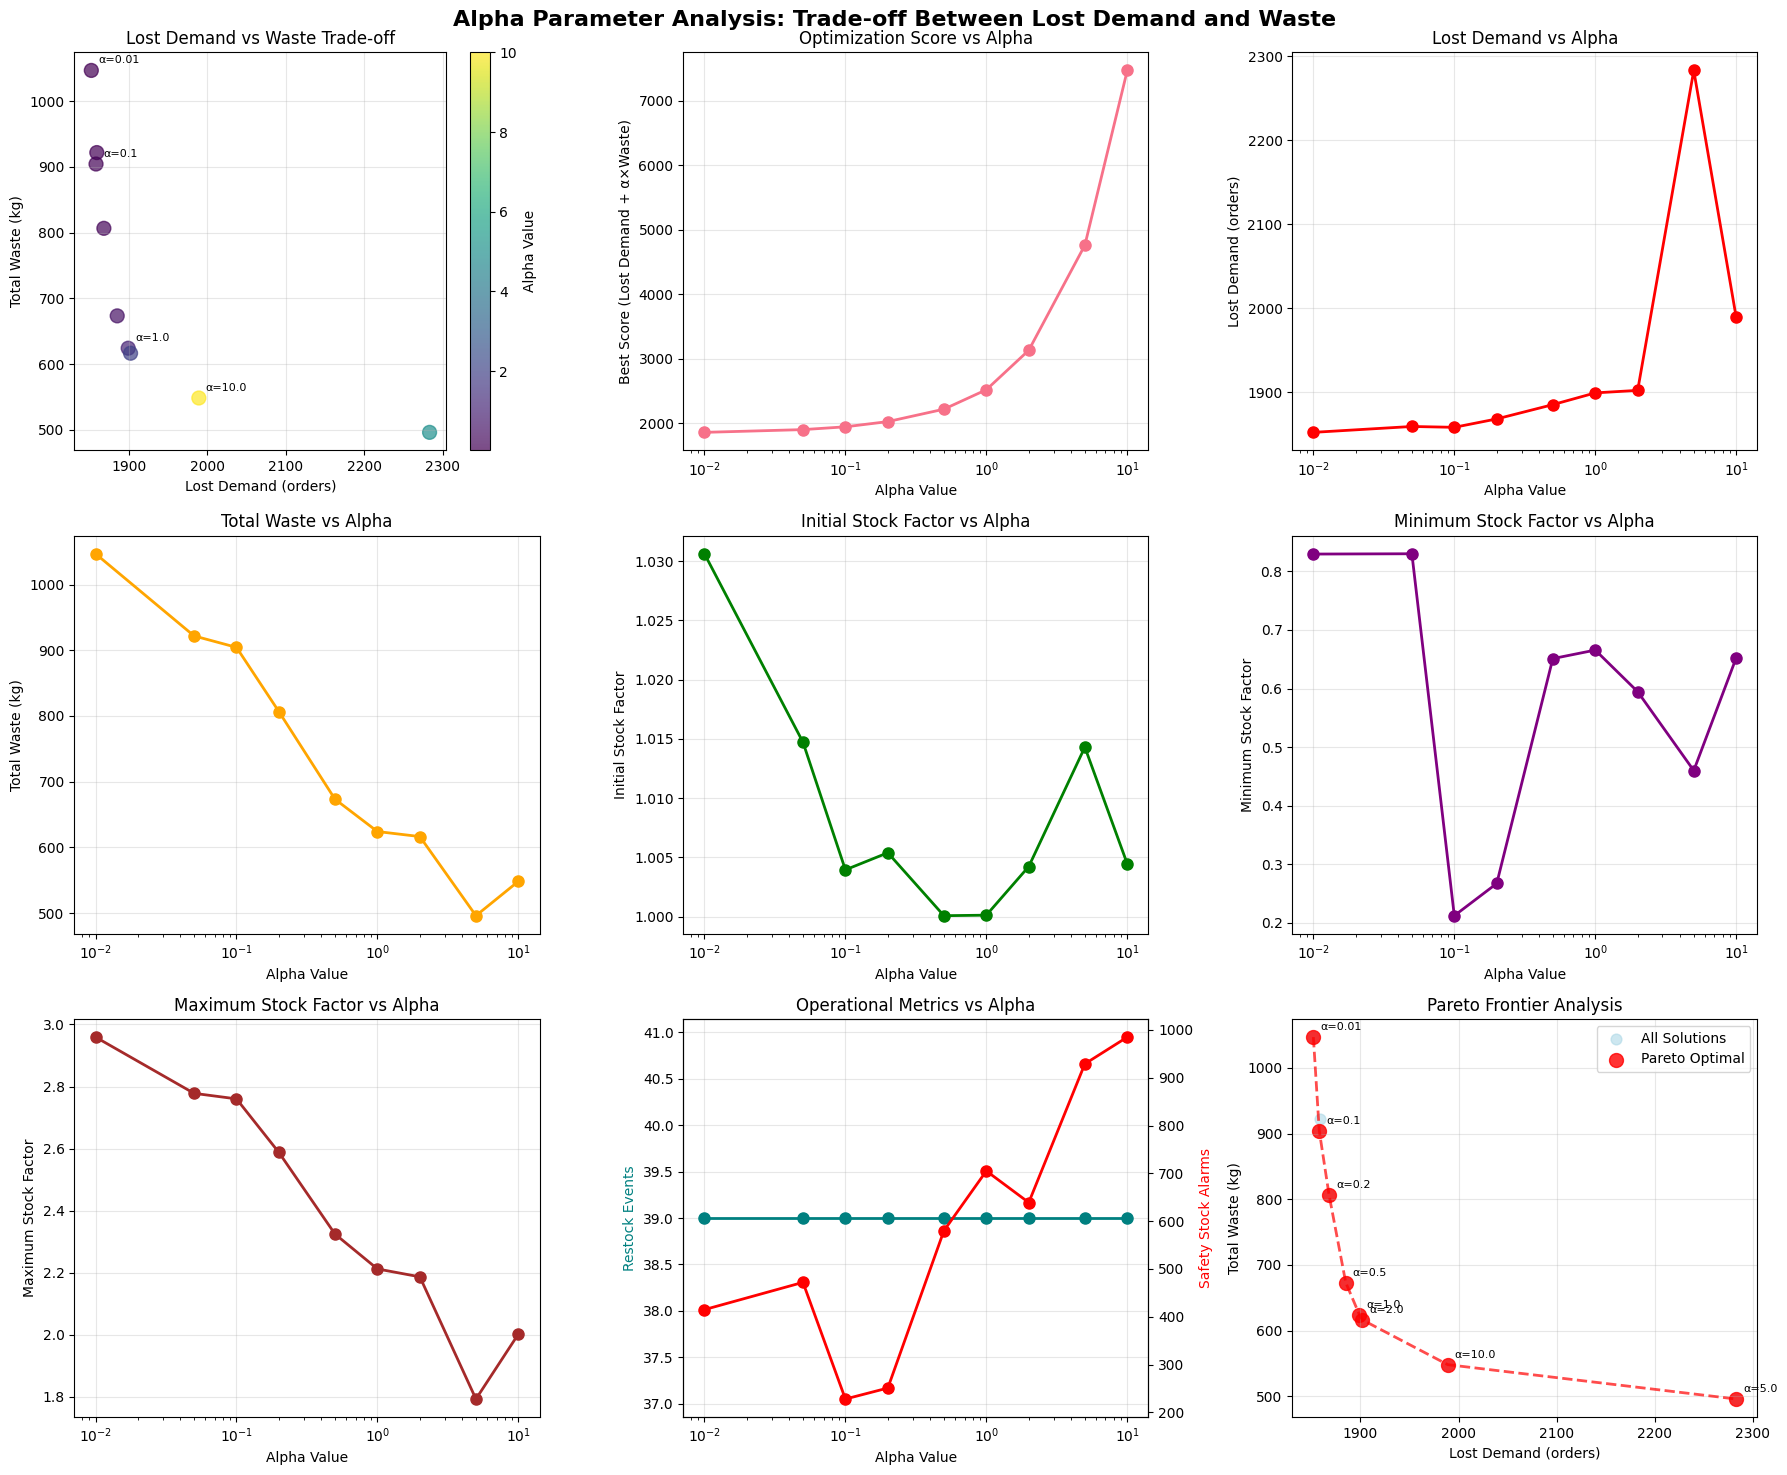


Creating summary table...
ALPHA ANALYSIS SUMMARY TABLE
 alpha  best_score  lost_demand  lost_demand_percentage  waste_total_kg  waste_percentage  init_factor  min_factor  max_factor
  0.01    1862.469         1852                   3.736        1046.903             6.183        1.031       0.830       2.959
  0.05    1905.093         1859                   3.750         921.861             5.444        1.015       0.830       2.778
  0.10    1948.443         1858                   3.748         904.432             5.342        1.004       0.212       2.760
  0.20    2029.313         1868                   3.768         806.563             4.764        1.005       0.267       2.587
  0.50    2221.650         1885                   3.802         673.300             3.976        1.000       0.651       2.325
  1.00    2523.080         1899                   3.831         624.080             3.686        1.000       0.666       2.212
  2.00    3134.858         1902                   3.837

In [17]:
# Comprehensive Visualization of Alpha Analysis Results

def create_alpha_visualizations(alpha_results):
    """Create comprehensive visualizations for alpha analysis"""
    
    # Set up the plotting style
    plt.style.use('default')
    sns.set_palette("husl")
    
    # Create a large figure with multiple subplots
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    fig.suptitle('Alpha Parameter Analysis: Trade-off Between Lost Demand and Waste', fontsize=16, fontweight='bold')
    
    # 1. Primary Trade-off: Lost Demand vs Waste
    ax1 = axes[0, 0]
    scatter = ax1.scatter(alpha_results['lost_demand'], alpha_results['waste_total_kg'], 
                         c=alpha_results['alpha'], s=100, cmap='viridis', alpha=0.7)
    ax1.set_xlabel('Lost Demand (orders)')
    ax1.set_ylabel('Total Waste (kg)')
    ax1.set_title('Lost Demand vs Waste Trade-off')
    ax1.grid(True, alpha=0.3)
    cbar1 = plt.colorbar(scatter, ax=ax1)
    cbar1.set_label('Alpha Value')
    
    # Add annotations for key points
    for i, row in alpha_results.iterrows():
        if row['alpha'] in [0.01, 0.1, 1.0, 10.0]:
            ax1.annotate(f'α={row["alpha"]}', 
                        (row['lost_demand'], row['waste_total_kg']),
                        xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    # 2. Alpha vs Best Score
    ax2 = axes[0, 1]
    ax2.plot(alpha_results['alpha'], alpha_results['best_score'], 'o-', linewidth=2, markersize=8)
    ax2.set_xlabel('Alpha Value')
    ax2.set_ylabel('Best Score (Lost Demand + α×Waste)')
    ax2.set_title('Optimization Score vs Alpha')
    ax2.set_xscale('log')
    ax2.grid(True, alpha=0.3)
    
    # 3. Alpha vs Lost Demand
    ax3 = axes[0, 2]
    ax3.plot(alpha_results['alpha'], alpha_results['lost_demand'], 'o-', 
             color='red', linewidth=2, markersize=8)
    ax3.set_xlabel('Alpha Value')
    ax3.set_ylabel('Lost Demand (orders)')
    ax3.set_title('Lost Demand vs Alpha')
    ax3.set_xscale('log')
    ax3.grid(True, alpha=0.3)
    
    # 4. Alpha vs Waste
    ax4 = axes[1, 0]
    ax4.plot(alpha_results['alpha'], alpha_results['waste_total_kg'], 'o-', 
             color='orange', linewidth=2, markersize=8)
    ax4.set_xlabel('Alpha Value')
    ax4.set_ylabel('Total Waste (kg)')
    ax4.set_title('Total Waste vs Alpha')
    ax4.set_xscale('log')
    ax4.grid(True, alpha=0.3)
    
    # 5. Parameter Evolution: Init Factor
    ax5 = axes[1, 1]
    ax5.plot(alpha_results['alpha'], alpha_results['init_factor'], 'o-', 
             color='green', linewidth=2, markersize=8)
    ax5.set_xlabel('Alpha Value')
    ax5.set_ylabel('Initial Stock Factor')
    ax5.set_title('Initial Stock Factor vs Alpha')
    ax5.set_xscale('log')
    ax5.grid(True, alpha=0.3)
    
    # 6. Parameter Evolution: Min Factor
    ax6 = axes[1, 2]
    ax6.plot(alpha_results['alpha'], alpha_results['min_factor'], 'o-', 
             color='purple', linewidth=2, markersize=8)
    ax6.set_xlabel('Alpha Value')
    ax6.set_ylabel('Minimum Stock Factor')
    ax6.set_title('Minimum Stock Factor vs Alpha')
    ax6.set_xscale('log')
    ax6.grid(True, alpha=0.3)
    
    # 7. Parameter Evolution: Max Factor
    ax7 = axes[2, 0]
    ax7.plot(alpha_results['alpha'], alpha_results['max_factor'], 'o-', 
             color='brown', linewidth=2, markersize=8)
    ax7.set_xlabel('Alpha Value')
    ax7.set_ylabel('Maximum Stock Factor')
    ax7.set_title('Maximum Stock Factor vs Alpha')
    ax7.set_xscale('log')
    ax7.grid(True, alpha=0.3)
    
    # 8. Efficiency Metrics
    ax8 = axes[2, 1]
    ax8.plot(alpha_results['alpha'], alpha_results['restock_events'], 'o-', 
             color='teal', linewidth=2, markersize=8, label='Restock Events')
    ax8_twin = ax8.twinx()
    ax8_twin.plot(alpha_results['alpha'], alpha_results['safety_stock_alarms'], 'o-', 
                  color='red', linewidth=2, markersize=8, label='Safety Alarms')
    ax8.set_xlabel('Alpha Value')
    ax8.set_ylabel('Restock Events', color='teal')
    ax8_twin.set_ylabel('Safety Stock Alarms', color='red')
    ax8.set_title('Operational Metrics vs Alpha')
    ax8.set_xscale('log')
    ax8_twin.set_xscale('log')
    ax8.grid(True, alpha=0.3)
    
    # 9. Pareto Frontier Analysis
    ax9 = axes[2, 2]
    # Calculate Pareto frontier
    pareto_points = []
    for i, row1 in alpha_results.iterrows():
        is_pareto = True
        for j, row2 in alpha_results.iterrows():
            if i != j:
                if (row2['lost_demand'] <= row1['lost_demand'] and 
                    row2['waste_total_kg'] <= row1['waste_total_kg'] and
                    (row2['lost_demand'] < row1['lost_demand'] or 
                     row2['waste_total_kg'] < row1['waste_total_kg'])):
                    is_pareto = False
                    break
        if is_pareto:
            pareto_points.append(i)
    
    # Plot all points
    ax9.scatter(alpha_results['lost_demand'], alpha_results['waste_total_kg'], 
               c='lightblue', alpha=0.6, s=60, label='All Solutions')
    
    # Highlight Pareto optimal points
    pareto_data = alpha_results.iloc[pareto_points]
    ax9.scatter(pareto_data['lost_demand'], pareto_data['waste_total_kg'], 
               c='red', s=100, label='Pareto Optimal', alpha=0.8)
    
    # Connect Pareto points
    pareto_sorted = pareto_data.sort_values('lost_demand')
    ax9.plot(pareto_sorted['lost_demand'], pareto_sorted['waste_total_kg'], 
            'r--', alpha=0.7, linewidth=2)
    
    ax9.set_xlabel('Lost Demand (orders)')
    ax9.set_ylabel('Total Waste (kg)')
    ax9.set_title('Pareto Frontier Analysis')
    ax9.legend()
    ax9.grid(True, alpha=0.3)
    
    # Annotate Pareto points with alpha values
    for _, row in pareto_data.iterrows():
        ax9.annotate(f'α={row["alpha"]}', 
                    (row['lost_demand'], row['waste_total_kg']),
                    xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    return fig

def create_alpha_summary_table(alpha_results):
    """Create a formatted summary table of alpha analysis"""
    
    # Calculate some additional metrics
    alpha_results_copy = alpha_results.copy()
    alpha_results_copy['waste_percentage'] = (alpha_results_copy['waste_total_kg'] / 
                                            grand_total_usage * 100)
    alpha_results_copy['lost_demand_percentage'] = (alpha_results_copy['lost_demand'] / 
                                                   df['quantity'].sum() * 100)
    
    # Round values for display
    display_cols = ['alpha', 'best_score', 'lost_demand', 'lost_demand_percentage',
                   'waste_total_kg', 'waste_percentage', 'init_factor', 'min_factor', 'max_factor']
    
    summary = alpha_results_copy[display_cols].round(3)
    
    print("="*100)
    print("ALPHA ANALYSIS SUMMARY TABLE")
    print("="*100)
    print(summary.to_string(index=False))
    print("="*100)
    
    # Find the best alpha for different criteria
    best_lost_demand = alpha_results_copy.loc[alpha_results_copy['lost_demand'].idxmin()]
    best_waste = alpha_results_copy.loc[alpha_results_copy['waste_total_kg'].idxmin()]
    best_score = alpha_results_copy.loc[alpha_results_copy['best_score'].idxmin()]
    
    print(f"\nKEY FINDINGS:")
    print(f"Best for minimizing lost demand: α = {best_lost_demand['alpha']} "
          f"(Lost: {best_lost_demand['lost_demand']}, Waste: {best_lost_demand['waste_total_kg']:.1f} kg)")
    print(f"Best for minimizing waste: α = {best_waste['alpha']} "
          f"(Lost: {best_waste['lost_demand']}, Waste: {best_waste['waste_total_kg']:.1f} kg)")
    print(f"Best overall score: α = {best_score['alpha']} "
          f"(Score: {best_score['best_score']:.1f})")
    
    return summary

# Run the visualizations after the optimization completes
print("Creating visualizations...")
fig = create_alpha_visualizations(alpha_results)

print("\nCreating summary table...")
summary_table = create_alpha_summary_table(alpha_results)

Running full year analysis with optimized parameters...
Analyzing alpha = 0.01...
  Lost demand: 5,980 orders (12.06%)
  Waste: 3379.7 kg (19.96%)
  Combined score: 6013.8

Analyzing alpha = 0.05...
  Lost demand: 6,024 orders (12.15%)
  Waste: 2867.9 kg (16.94%)
  Combined score: 6167.4

Analyzing alpha = 0.1...
  Lost demand: 6,032 orders (12.17%)
  Waste: 2814.4 kg (16.62%)
  Combined score: 6313.4

Analyzing alpha = 0.2...
  Lost demand: 6,105 orders (12.31%)
  Waste: 2386.3 kg (14.09%)
  Combined score: 6582.3

Analyzing alpha = 0.5...
  Lost demand: 6,244 orders (12.60%)
  Waste: 1818.4 kg (10.74%)
  Combined score: 7153.2

Analyzing alpha = 1.0...
  Lost demand: 6,376 orders (12.86%)
  Waste: 1609.6 kg (9.51%)
  Combined score: 7985.6

Analyzing alpha = 2.0...
  Lost demand: 6,419 orders (12.95%)
  Waste: 1568.1 kg (9.26%)
  Combined score: 9555.2

Analyzing alpha = 5.0...
  Lost demand: 8,325 orders (16.79%)
  Waste: 1013.9 kg (5.99%)
  Combined score: 13394.7

Analyzing alpha 

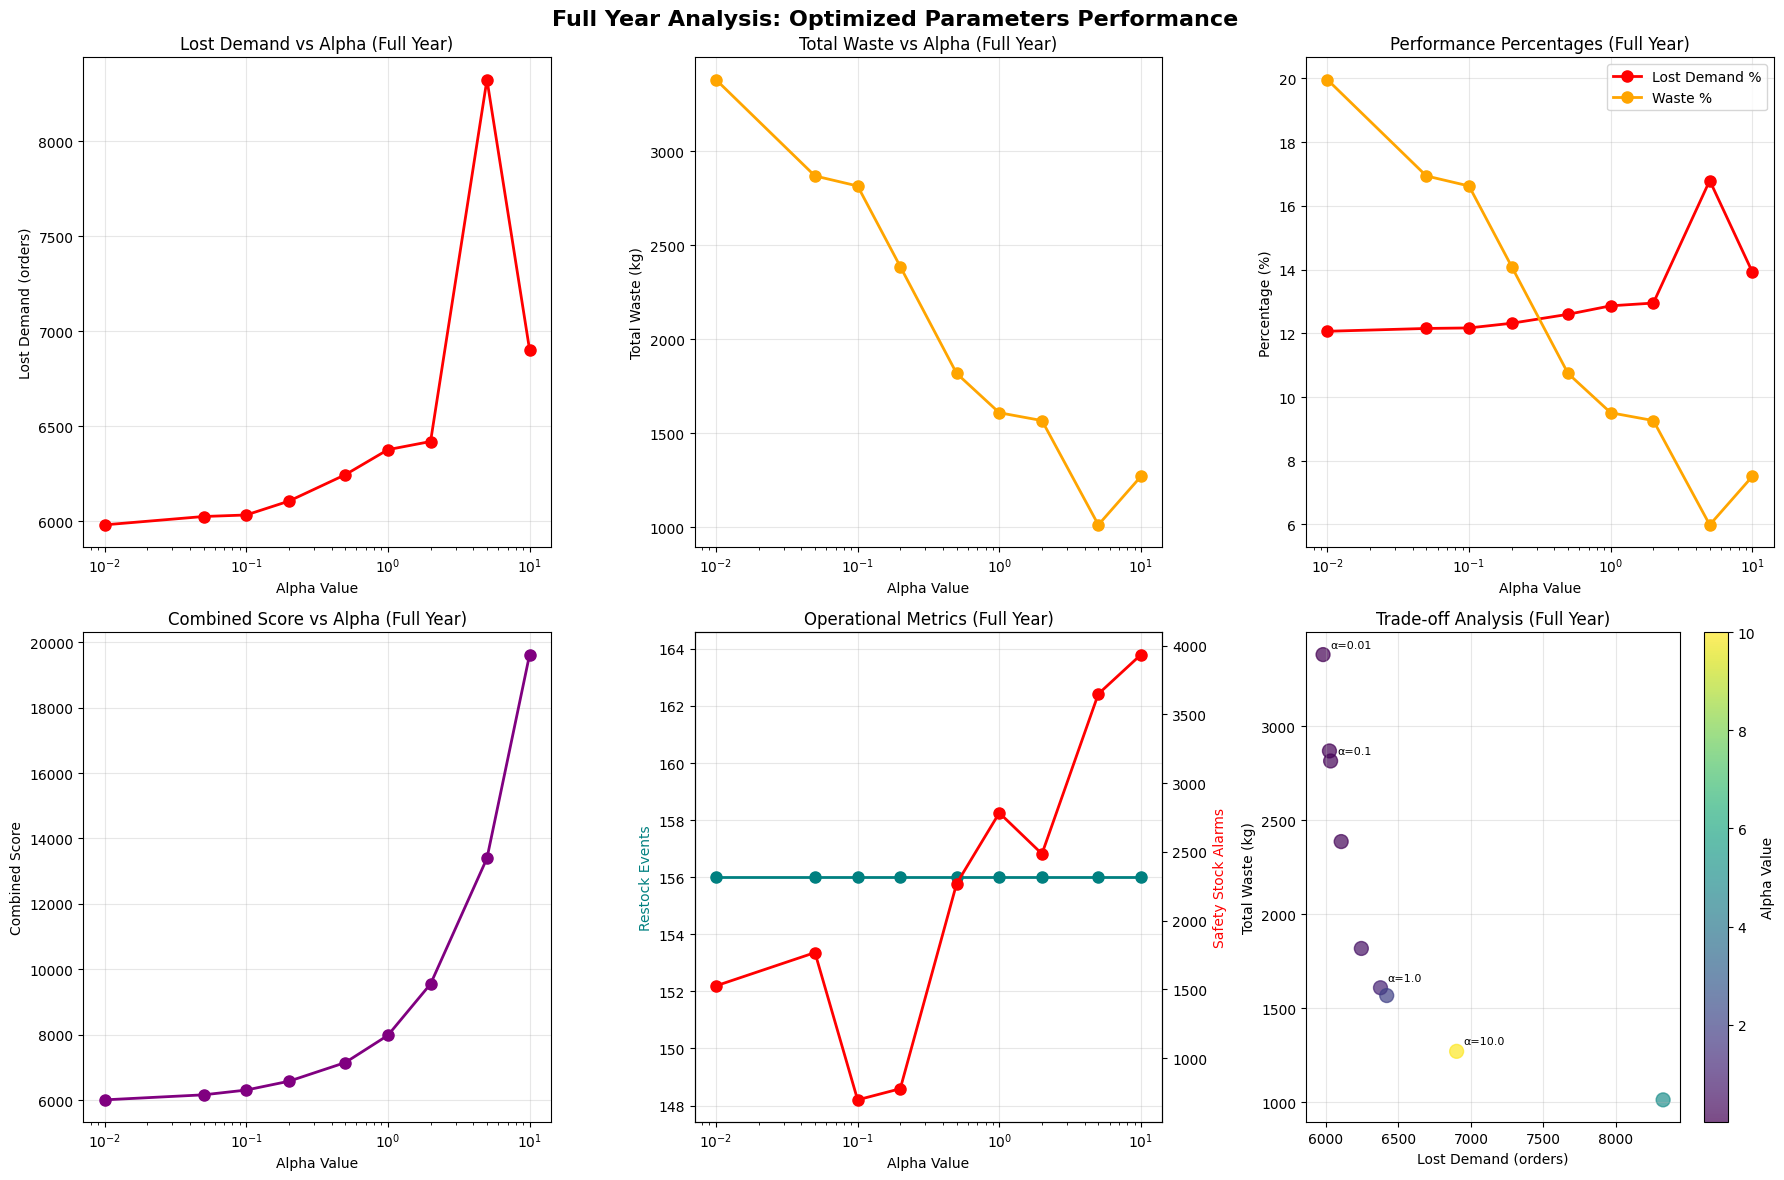


Generating full year summary...
FULL YEAR ANALYSIS SUMMARY
 alpha  lost_demand  lost_demand_percentage  waste_total_kg  waste_percentage  combined_score  restock_events  safety_stock_alarms
  0.01         5980                   12.06         3379.70             19.96         6013.80             156                 1526
  0.05         6024                   12.15         2867.85             16.94         6167.39             156                 1768
  0.10         6032                   12.17         2814.43             16.62         6313.44             156                  697
  0.20         6105                   12.31         2386.32             14.09         6582.26             156                  778
  0.50         6244                   12.60         1818.38             10.74         7153.19             156                 2270
  1.00         6376                   12.86         1609.64              9.51         7985.64             156                 2784
  2.00         6419    

In [20]:
import pandas as pd
import matplotlib.pyplot as plt

# Full Year Analysis with Optimized Parameters
def run_full_year_analysis(alpha_results: pd.DataFrame) -> pd.DataFrame:
    """
    Run simulation for the full year using the best parameters from each alpha.
    Requires in scope:
      - daily_ingredient_usage (pd.DataFrame with datetime index)
      - shelf_life_days (dict)
      - ingredient_masses_kg (dict)
      - df (orders DataFrame with 'quantity')
      - recipes_dict (dict)
      - grand_total_usage (float)
      - simulate_inventory (callable)
    """
    print("Running full year analysis with optimized parameters...")
    print("=" * 80)

    full_year_results = []

    for _, row in alpha_results.iterrows():
        alpha = row["alpha"]
        print(f"Analyzing alpha = {alpha}...")

        # Create inventory parameters using the optimized factors
        def create_optimized_params(init_factor: float, min_factor: float, max_factor: float) -> pd.DataFrame:
            first_two_weeks = daily_ingredient_usage[
                (daily_ingredient_usage.index >= "2015-01-01")
                & (daily_ingredient_usage.index < "2015-01-15")
            ]
            first_three_months = daily_ingredient_usage[
                (daily_ingredient_usage.index >= "2015-01-01")
                & (daily_ingredient_usage.index < "2015-04-01")
            ]

            inventory_parameters = []
            for ingredient in daily_ingredient_usage.columns:
                initial_stock = first_two_weeks[ingredient].sum() * init_factor
                max_daily_demand = first_three_months[ingredient].max()
                max_stock = max_daily_demand * max_factor
                min_stock = max_daily_demand * min_factor
                shelf_life = shelf_life_days.get(ingredient, 7)

                inventory_parameters.append(
                    {
                        "ingredient": ingredient,
                        "initial_stock_kg": initial_stock,
                        "max_stock_kg": max_stock,
                        "min_stock_kg": min_stock,
                        "shelf_life_days": shelf_life,
                        "mass_per_pizza_kg": ingredient_masses_kg.get(ingredient, 0),
                    }
                )
            return pd.DataFrame(inventory_parameters).set_index("ingredient")

        # Create parameters with optimized factors
        optimized_params = create_optimized_params(
            float(row["init_factor"]),
            float(row["min_factor"]),
            float(row["max_factor"]),
        )

        # Run simulation for full year
        full_year_result = simulate_inventory(
            df=df,
            inventory_parameters=optimized_params,
            recipes_dict=recipes_dict,
            ingredient_masses_kg=ingredient_masses_kg,
            start_date="2015-01-01",
            end_date="2015-12-31",  # Full year
            restock_interval_days=5,
            alarm_threshold=2,
        )

        # Calculate percentages
        total_orders = float(df["quantity"].sum())
        waste_percentage = (full_year_result["waste_total_kg"] / float(grand_total_usage)) * 100.0
        lost_demand_percentage = (full_year_result["lost_demand"] / total_orders) * 100.0

        # Store results
        combined_score = full_year_result["lost_demand"] + alpha * full_year_result["waste_total_kg"]
        result_data = {
            "alpha": alpha,
            "init_factor": float(row["init_factor"]),
            "min_factor": float(row["min_factor"]),
            "max_factor": float(row["max_factor"]),
            "lost_demand": full_year_result["lost_demand"],
            "lost_demand_percentage": lost_demand_percentage,
            "waste_total_kg": full_year_result["waste_total_kg"],
            "waste_percentage": waste_percentage,
            "restock_events": full_year_result["restock_events"],
            "safety_stock_alarms": full_year_result["safety_stock_alarms"],
            "final_restock_interval": full_year_result["final_restock_interval_days"],
            "combined_score": combined_score,
        }

        full_year_results.append(result_data)

        print(f"  Lost demand: {full_year_result['lost_demand']:,} orders ({lost_demand_percentage:.2f}%)")
        print(f"  Waste: {full_year_result['waste_total_kg']:.1f} kg ({waste_percentage:.2f}%)")
        print(f"  Combined score: {combined_score:.1f}\n")

    return pd.DataFrame(full_year_results)


def create_full_year_visualizations(full_year_results: pd.DataFrame):
    """Create visualizations for full year results."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle("Full Year Analysis: Optimized Parameters Performance", fontsize=16, fontweight="bold")

    # 1. Lost Demand vs Alpha
    ax1 = axes[0, 0]
    ax1.plot(full_year_results["alpha"], full_year_results["lost_demand"], "o-", linewidth=2, markersize=8, color="red")
    ax1.set_xlabel("Alpha Value")
    ax1.set_ylabel("Lost Demand (orders)")
    ax1.set_title("Lost Demand vs Alpha (Full Year)")
    ax1.set_xscale("log")
    ax1.grid(True, alpha=0.3)

    # 2. Waste vs Alpha
    ax2 = axes[0, 1]
    ax2.plot(
        full_year_results["alpha"],
        full_year_results["waste_total_kg"],
        "o-",
        linewidth=2,
        markersize=8,
        color="orange",
    )
    ax2.set_xlabel("Alpha Value")
    ax2.set_ylabel("Total Waste (kg)")
    ax2.set_title("Total Waste vs Alpha (Full Year)")
    ax2.set_xscale("log")
    ax2.grid(True, alpha=0.3)

    # 3. Percentage Metrics
    ax3 = axes[0, 2]
    ax3.plot(
        full_year_results["alpha"],
        full_year_results["lost_demand_percentage"],
        "o-",
        linewidth=2,
        markersize=8,
        color="red",
        label="Lost Demand %",
    )
    ax3.plot(
        full_year_results["alpha"],
        full_year_results["waste_percentage"],
        "o-",
        linewidth=2,
        markersize=8,
        color="orange",
        label="Waste %",
    )
    ax3.set_xlabel("Alpha Value")
    ax3.set_ylabel("Percentage (%)")
    ax3.set_title("Performance Percentages (Full Year)")
    ax3.set_xscale("log")
    ax3.grid(True, alpha=0.3)
    ax3.legend()

    # 4. Combined Score
    ax4 = axes[1, 0]
    ax4.plot(
        full_year_results["alpha"],
        full_year_results["combined_score"],
        "o-",
        linewidth=2,
        markersize=8,
        color="purple",
    )
    ax4.set_xlabel("Alpha Value")
    ax4.set_ylabel("Combined Score")
    ax4.set_title("Combined Score vs Alpha (Full Year)")
    ax4.set_xscale("log")
    ax4.grid(True, alpha=0.3)

    # 5. Operational Metrics
    ax5 = axes[1, 1]
    ax5.plot(
        full_year_results["alpha"],
        full_year_results["restock_events"],
        "o-",
        linewidth=2,
        markersize=8,
        color="teal",
        label="Restock Events",
    )
    ax5_twin = ax5.twinx()
    ax5_twin.plot(
        full_year_results["alpha"],
        full_year_results["safety_stock_alarms"],
        "o-",
        linewidth=2,
        markersize=8,
        color="red",
        label="Safety Alarms",
    )
    ax5.set_xlabel("Alpha Value")
    ax5.set_ylabel("Restock Events", color="teal")
    ax5_twin.set_ylabel("Safety Stock Alarms", color="red")
    ax5.set_title("Operational Metrics (Full Year)")
    ax5.set_xscale("log")
    ax5_twin.set_xscale("log")
    ax5.grid(True, alpha=0.3)

    # 6. Trade-off Analysis
    ax6 = axes[1, 2]
    scatter = ax6.scatter(
        full_year_results["lost_demand"],
        full_year_results["waste_total_kg"],
        c=full_year_results["alpha"],
        s=100,
        cmap="viridis",
        alpha=0.7,
    )
    ax6.set_xlabel("Lost Demand (orders)")
    ax6.set_ylabel("Total Waste (kg)")
    ax6.set_title("Trade-off Analysis (Full Year)")
    ax6.grid(True, alpha=0.3)

    # Add colorbar
    cbar = plt.colorbar(scatter, ax=ax6)
    cbar.set_label("Alpha Value")

    # Add annotations for key alpha values
    for _, r in full_year_results.iterrows():
        if r["alpha"] in [0.01, 0.1, 1.0, 10.0]:
            ax6.annotate(
                f"α={r['alpha']}",
                (r["lost_demand"], r["waste_total_kg"]),
                xytext=(5, 5),
                textcoords="offset points",
                fontsize=8,
            )

    plt.tight_layout()
    plt.show()
    return fig


def create_full_year_summary(full_year_results: pd.DataFrame) -> pd.DataFrame:
    """Create detailed summary of full year results."""
    print("=" * 100)
    print("FULL YEAR ANALYSIS SUMMARY")
    print("=" * 100)

    # Display results table
    display_cols = [
        "alpha",
        "lost_demand",
        "lost_demand_percentage",
        "waste_total_kg",
        "waste_percentage",
        "combined_score",
        "restock_events",
        "safety_stock_alarms",
    ]
    summary_display = full_year_results[display_cols].round(2)
    print(summary_display.to_string(index=False))

    print("\n" + "=" * 100)
    print("KEY PERFORMANCE INDICATORS")
    print("=" * 100)

    # Find best performers
    best_lost_demand = full_year_results.loc[full_year_results["lost_demand"].idxmin()]
    best_waste = full_year_results.loc[full_year_results["waste_total_kg"].idxmin()]
    best_combined = full_year_results.loc[full_year_results["combined_score"].idxmin()]

    print("BEST FOR MINIMIZING LOST DEMAND:")
    print(
        f"  Alpha: {best_lost_demand['alpha']}\n"
        f"  Lost demand: {best_lost_demand['lost_demand']:,} orders "
        f"({best_lost_demand['lost_demand_percentage']:.2f}%)\n"
        f"  Waste: {best_lost_demand['waste_total_kg']:.1f} kg "
        f"({best_lost_demand['waste_percentage']:.2f}%)\n"
        f"  Parameters: init={best_lost_demand['init_factor']:.2f}, "
        f"min={best_lost_demand['min_factor']:.2f}, max={best_lost_demand['max_factor']:.2f}"
    )
    print()

    print("BEST FOR MINIMIZING WASTE:")
    print(
        f"  Alpha: {best_waste['alpha']}\n"
        f"  Lost demand: {best_waste['lost_demand']:,} orders "
        f"({best_waste['lost_demand_percentage']:.2f}%)\n"
        f"  Waste: {best_waste['waste_total_kg']:.1f} kg "
        f"({best_waste['waste_percentage']:.2f}%)\n"
        f"  Parameters: init={best_waste['init_factor']:.2f}, "
        f"min={best_waste['min_factor']:.2f}, max={best_waste['max_factor']:.2f}"
    )
    print()

    print("BEST OVERALL (LOWEST COMBINED SCORE):")
    print(
        f"  Alpha: {best_combined['alpha']}\n"
        f"  Lost demand: {best_combined['lost_demand']:,} orders "
        f"({best_combined['lost_demand_percentage']:.2f}%)\n"
        f"  Waste: {best_combined['waste_total_kg']:.1f} kg "
        f"({best_combined['waste_percentage']:.2f}%)\n"
        f"  Combined score: {best_combined['combined_score']:.1f}\n"
        f"  Parameters: init={best_combined['init_factor']:.2f}, "
        f"min={best_combined['min_factor']:.2f}, max={best_combined['max_factor']:.2f}"
    )
    print()

    return summary_display


# Run the full year analysis
full_year_results = run_full_year_analysis(alpha_results)

# Create visualizations
print("\nCreating full year visualizations...")
full_year_fig = create_full_year_visualizations(full_year_results)

# Create summary
print("\nGenerating full year summary...")
full_year_summary = create_full_year_summary(full_year_results)
